# Imports and setup 

In [1]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Annotated, List, Dict, TypedDict, Any
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain.pydantic_v1 import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from tavily import TavilyClient
from langchain_core.prompts import(
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder
)
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import functools
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
from datetime import datetime
import traceback
import json
import os 
import re
import spacy

C:\Users\Kit\PycharmProjects\SEO_AI\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# os.environ["OPENAI_API_KEY"] = " "
# os.environ["ANTHROPIC_API_KEY"] = " "
# os.environ["TAVILY_API_KEY"] = " "

# Initialising models 

In [3]:
gpt4o_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.35)
claude_sonnet = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Initialising the agent state

In [4]:
class AgentState(TypedDict):
    topic: str  # user input
    seo_data: Any
    
    stats: Any # actual tavily search result
    relevant_data_stats: Any # yes/no
    stats_review: Any # Why data isnt enough or relevant feedback 
    
    located_quotes: Any # 1. generated queries 2. actual returned search data
    relevant_data_quotes: Any # yes/no
    quotes_review: Any # Why data isnt enough or relevant feedback 
    stats_raw_content: Any
    
    topic_search: Any # 1. generated queries 2. actual returned search data
    topic_data_all: Any
    relevant_data_topicsearch: Any # yes/no
    topic_search_review: Any # Why data isnt enough or relevant feedback 

    writing_examples: Any # Place holder for user input of writing styles 
    writing_plan: Any
    writing_style: Any # make sure that the current workflow waits for this to be filled from assess writing style node
    article: Any
    editor_notes: Any
    
    sender: Any
    messages: Annotated[list, operator.add]

# Setting tools 
## Grading function

In [5]:
class Gradequestion(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


system = """You are a grader assessing if there is enough relevant data related to the task provided. \n 
    It does not need to be a stringent test. The goal is to ensure that there is useful data so that we can later generate an article. \n
    If the user data provides enough information to help you output draft an article, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Data : {data}"),
    ]
)

structured_llm_grader = gpt4o_model.with_structured_output(Gradequestion)


query_grader = grade_prompt | structured_llm_grader


# Decide to continue functions 
def decide_to_continue_topic(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_topicsearch"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_topic"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "checkpointer"


def decide_to_continue_stats(state):
    """
    Determines whether to generate an answer, or ask an additional question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    enough_context = state["relevant_data_stats"]
    print(enough_context)
        
    if enough_context == []:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
        )
        return "review_node_stats"
    else:
        # We have relevant context, so continue to gather user requirements
        print("---DECISION: GATHER REQUIREMENTS---")
        return "checkpointer"



# def decide_to_continue_quotes(state):
#     """
#     Determines whether to generate an answer, or ask an additional question.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         str: Binary decision for next node to call
#     """

#     print("---ASSESS GRADED DOCUMENTS---")
#     enough_context = state["relevant_data_quotes"]
#     print(enough_context)
        
#     if enough_context == []:
#         # All documents have been filtered check_relevance
#         # We will re-generate a new query
#         print(
#             "---DECISION: QUERY DOES NOT PROVIDE ENOUGH CONTEXT ---"
#         )
#         return "review_node_quotes"
#     else:
#         # We have relevant context, so continue to gather user requirements
#         print("---DECISION: GATHER REQUIREMENTS---")
#         return "draft_article_node"







# Desicion nodes
def descision_node_topic(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["topic_search"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_topicsearch": enough_context}



def descision_node_stats(state):
    """
    Determines whether the data provided is relevant to the topic and task.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
    data = state["stats"]

    enough_context = []

    score = query_grader.invoke(
        {"data": data}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: QUESTION RELEVANT---")
        enough_context.append(grade)
    else:
        print("---GRADE: QUESTION NOT RELEVANT---")
    print(f"THIS WAS THE GRADE {grade}")
    return {"relevant_data_stats": enough_context}



# def descision_node_quotes(state):
#     """
#     Determines whether the data provided is relevant to the topic and task.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         state (dict): Updates documents key with only filtered relevant documents
#     """

#     print("---CHECK QUERY ENOUGH TO ANSWER QUESTION--")
#     data = state["quotes"]

#     enough_context = []

#     score = query_grader.invoke(
#         {"data": data}
#     )
#     grade = score.binary_score
#     if grade == "yes":
#         print("---GRADE: QUESTION RELEVANT---")
#         enough_context.append(grade)
#     else:
#         print("---GRADE: QUESTION NOT RELEVANT---")
#     print(f"THIS WAS THE GRADE {grade}")
#     return {"relevant_data_quotes": enough_context}

# Setting tools
## Search tools 

In [6]:
class Queries(BaseModel):
    queries: List[str]

# search_engine = DuckDuckGoSearchAPIWrapper()


@tool
def search_engine_topic(topic_search: Queries):
    """Search engine to the internet."""

    aggregate_search = []

    for q in topic_search.queries:
    
        print(f"Query: {q}")
        results = DuckDuckGoSearchAPIWrapper()._ddgs_text(q)
        aggregate_search.append(results)
    
    return {"topic_search": aggregate_search}

# @tool
# def search_engine_quotes(quotes: Queries):
#     """Search engine to the internet."""
#     aggregate_search = []

#     for q in quotes.queries:
    
#         print(f"Query: {q}")
#         results = DuckDuckGoSearchAPIWrapper()._ddgs_text(q)
#         aggregate_search.append(results)
#     return {"quotes": aggregate_search}



# Alternative version using Unicode escape sequences
def clean_text(raw_text: str) -> str:
    """
    Basic text cleaning function with Unicode quote handling.
    """
    # Remove HTML tags if present
    text = re.sub(r'<[^>]+>', ' ', raw_text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Normalize smart quotes to regular quotes
    text = text.replace('\u2018', "'")  # Left single quote
    text = text.replace('\u2019', "'")  # Right single quote
    text = text.replace('\u201c', '"')  # Left double quote
    text = text.replace('\u201d', '"')  # Right double quote
    
    # Remove special characters but keep quotes and basic punctuation
    text = re.sub(r'[^\w\s.,!?"\']', ' ', text)
    
    # Normalize spaces around quotes
    text = re.sub(r'\s*"\s*', '" ', text)
    text = re.sub(r'\s*\'\s*', "' ", text)
    
    return text.strip()



def process_quotes(state):
    """
    Extract and analyze quotes from multiple URL sources.
    
    Args:
        state (dict): Contains two dictionaries of URL-content pairs:
                     - stats_raw_content: {url: content}
                     - topic_data_all: {url: content}
    
    Returns:
        dict: Contains 'located_quotes' list of dictionaries with quote information:
              - quote: The extracted quote
              - speaker: Who said it (if found)
              - context: Surrounding text
              - confidence: Confidence score
              - source_url: URL where the quote was found
    """
    # Initialize spaCy
    nlp = spacy.load("en_core_web_sm")
    window_size = 100  # Made explicit since we removed from parameters
    
    # Store results and track processed quotes (now with URLs)
    quote_results = []
    processed_quotes = set()  # Using (quote, url) tuples to allow same quote from different sources
    
    # Process both dictionaries
    all_sources = {
        **state["stats_raw_content"],
        **state["topic_data_all"]
    }
    
    # Define patterns (moved outside loop for efficiency)
    quote_patterns = [
        r'"([^"]*)"',      # Regular double quotes
        r'\'([^\']*)\'',   # Regular single quotes
        r'"([^"]*)"',      # Left/right double quotes
        r'["""]([^"""]*)[""]'  # Various double quotes
    ]
    
    speaking_verbs = (
        r'(?:said|says|told|stated|explained|noted|added|commented|mentioned|'
        r'claimed|announced|declared|suggested|responded|replied|concluded|'
        r'according to|as per)'
    )
    
    attribution_pattern = f'([^.!?]+{speaking_verbs}[^.!?]+[.!?])'
    
    # Process each URL's content
    for url, raw_text in all_sources.items():
        # Clean the text
        clean_content = clean_text(raw_text)
        
        # First pass: Look for quotes with attribution
        attribution_matches = re.finditer(attribution_pattern, clean_content, re.IGNORECASE)
        for match in attribution_matches:
            sentence = match.group(1).strip()
            
            # Find quotes in the attribution sentence
            for quote_pattern in quote_patterns:
                quote_matches = re.finditer(quote_pattern, sentence)
                for quote_match in quote_matches:
                    quote = quote_match.group(1).strip()
                    
                    # Use tuple of quote and URL to allow same quote from different sources
                    quote_key = (quote, url)
                    if not quote or quote_key in processed_quotes:
                        continue
                    
                    # Validate quote using spaCy
                    doc = nlp(quote)
                    
                    # Calculate confidence score
                    confidence = 0.0
                    if len(doc) > 3:  # More than 3 tokens
                        confidence += 0.3
                    if any(token.pos_ == "VERB" for token in doc):  # Contains verb
                        confidence += 0.3
                    if len(quote) > 10:  # Reasonable length
                        confidence += 0.2
                    if any(token.pos_ == "PRON" for token in doc):  # Contains pronouns
                        confidence += 0.2
                    
                    # Find quote location and context
                    quote_index = clean_content.find(quote)
                    if quote_index != -1:
                        # Extract surrounding context
                        start = max(0, quote_index - window_size)
                        end = min(len(clean_content), quote_index + len(quote) + window_size)
                        context = clean_content[start:end].strip()
                        
                        # Find speaker
                        before_quote = clean_content[max(0, quote_index - 50):quote_index]
                        after_quote = clean_content[quote_index + len(quote):min(len(clean_content), quote_index + len(quote) + 50)]
                        
                        speaker_pattern = f'{speaking_verbs}\s+([^,\.]+)'
                        speaker = None
                        
                        # Check before quote
                        speaker_match = re.search(speaker_pattern, after_quote, re.IGNORECASE)
                        if speaker_match:
                            speaker = speaker_match.group(1).strip()
                        else:
                            # Check after quote
                            speaker_match = re.search(f'([^,\.]+)\s+{speaking_verbs}', before_quote, re.IGNORECASE)
                            if speaker_match:
                                speaker = speaker_match.group(1).strip()
                        
                        quote_results.append({
                            'quote': quote,
                            'speaker': speaker,
                            'context': context,
                            'confidence': confidence,
                            'source_url': url
                        })
                        
                        processed_quotes.add(quote_key)
        
        # Second pass: Look for standalone quotes
        for pattern in quote_patterns:
            matches = re.finditer(pattern, clean_content)
            for match in matches:
                quote = match.group(1).strip()
                quote_key = (quote, url)
                
                if not quote or quote_key in processed_quotes:
                    continue
                    
                doc = nlp(quote)
                
                # Lower confidence for quotes without attribution
                confidence = 0.0
                if len(doc) > 3:
                    confidence += 0.2
                if any(token.pos_ == "VERB" for token in doc):
                    confidence += 0.2
                if len(quote) > 10:
                    confidence += 0.1
                
                quote_index = clean_content.find(quote)
                if quote_index != -1:
                    start = max(0, quote_index - window_size)
                    end = min(len(clean_content), quote_index + len(quote) + window_size)
                    context = clean_content[start:end].strip()
                    
                    quote_results.append({
                        'quote': quote,
                        'speaker': None,
                        'context': context,
                        'confidence': confidence,
                        'source_url': url
                    })
                    
                    processed_quotes.add(quote_key)
    
    # Sort results by confidence score
    quote_results.sort(key=lambda x: x['confidence'], reverse=True)
    
    return {"located_quotes": quote_results}
    


# Agentic QA
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

<>:157: SyntaxWarning: invalid escape sequence '\s'
<>:166: SyntaxWarning: invalid escape sequence '\.'
<>:157: SyntaxWarning: invalid escape sequence '\s'
<>:166: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Kit\AppData\Local\Temp\ipykernel_31384\1265327875.py:157: SyntaxWarning: invalid escape sequence '\s'
  speaker_pattern = f'{speaking_verbs}\s+([^,\.]+)'
C:\Users\Kit\AppData\Local\Temp\ipykernel_31384\1265327875.py:166: SyntaxWarning: invalid escape sequence '\.'
  speaker_match = re.search(f'([^,\.]+)\s+{speaking_verbs}', before_quote, re.IGNORECASE)


# Setting Nodes
## Review Nodes

In [7]:
def review_node_topic():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to review the research collected on the topic provided and answer why the data included is not enough or not relevant to our topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}")
    ])
    return {"topic_search_review": messages.content}

def review_node_stats():
    messages = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher.Your task is to review the research collected on the statistics about the topic we are researching. You must provide an answer to why the data included is not enough or not relevant to our task of getting quotes about the topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
        HumanMessage(content=f"Topic: {state['topic']}, Topic specific task: Stats data, data colletected: {state["stats"]}")
    ])
    return {"stats_review": messages.content}

# def review_node_quotes():
#     messages = gpt4o_model.with_structured_output(Queries).invoke([
#         SystemMessage(content="You are an expert researcher. Your task is to review the research collected on the quotes about the topic we are researching. You must provide an answer to why the data included is not enough or not relevant to our task of getting quotes about the topic. You must first read the data collected, Then output your thoughts on how it could be improved in terms of what else should be collected."),
#         HumanMessage(content=f"Topic: {state['topic']}, Topic specific task: quotes data, data collected: {state["quotes"]}")
#     ])
#     return {"quotes_review": messages.content}
    

# Setting nodes
## Main search Nodes

In [8]:
# This is okay could be improved. 
def researchq_topic_node(state: AgentState):

    raw_content = {}
    content = []
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to collect general research on the topic provided, this could be about the market, general industry trends ect. You will output a search query based on the relevant topic to collect this data. Please only output 3 queries"),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["topic_search_review"]}")
    ])

    content = state['topic_search'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=3, include_raw_content=True)
        for r in response['results']:
            content.append([r["content"], r["url"]])
            raw_content[r["url"]] = r["raw_content"]
    return {"topic_search": content, "topic_data_all": raw_content}


# This is good and returning relevant information. This is not a researchq because it is actually returning the data within it. 
def research_stats_node(state: AgentState):

    raw_content = {}
    content = []
    queries = gpt4o_model.with_structured_output(Queries).invoke([
        SystemMessage(content="You are an expert researcher. Your task is to collect statistics and other data on the topic provided. You will do this by generating a search query based on the topic the user has provided. Please generate 3 queries."),
        HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["stats_review"]}")
    ])
    content = state['stats'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=3, include_raw_content=True)
        for r in response['results']:
            content.append([r["content"], r["url"]])
            raw_content[r["url"]] = r["raw_content"]
    return {"stats": content, "stats_raw_content": raw_content}



# def researchq_quotes_node(state: AgentState):
#     queries = gpt4o_model.with_structured_output(Queries).invoke([
#         SystemMessage(content="We are creating an article based on a certain topic. In order for us to do this we need to find quotes on this topic. You will be given the topic. Your task is to output a search query to find quotes based on that topic. This is so that we can find relevant data. Please only output 2 queries"),
#         HumanMessage(content=f"Topic: {state['topic']}, feedback on previous collected data: {state["quotes_review"]}")
#     ])

#     print(f"Try this?: {queries}")
#     return {"quotes": queries}


In [9]:
# check point function 

def checkpointer(state):
    print("Waiting for both functions to complete")

# Synchronization check function
def check_completion(state):
    # Check if both branches have produced results
    if state["relevant_data_stats"] and state["relevant_data_topicsearch"] != []:
        return "READY"
    return "WAIT"

In [10]:
# Continued workflow

# Content writing workflow

In [11]:
def find_quotes_in_data(state: AgentState):

    raw_content = state["stats_raw_content"]
    located_quotes = []
    used_urls =[]
    for i in raw_content:
        url = i[1]
        print(f"PROCESSING DATA {i}, WITH THIS URL {url}")
        if url in used_urls:
            print(f"url already scanned {url}")
            pass
        else:
            print(f"url not used scanned {url}")
            try:
                messages = gpt4o_model.invoke([
                    SystemMessage(content="""please review the collected data given to you delimited in the triple exclamation marks. A quote must have: the quote andthe person or business that said the quote. If these three things are not met just say no quote found. \n 
                    in order to complete this task you must follow this structure. \n
                                                Step 1. Read the collected data \n
                                                Step 2. Identify any quotes from the article/data \n 
                                                Step 3. Output the quotes \n
                                                \n
                                                This is very important to make sure the right quote is attributed to the right URL and the correct source. """),
                    HumanMessage(content=f"Topic: {state['topic']}, collected data: {state["topic_search"]}")
                ])
                located_quotes.append([messages.content, url])
                used_urls.append(url)
            except:
                pass
        
    return {"located_quotes":located_quotes}

In [12]:
def assess_writing_style(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert writer. Your task is to review the examples given to you and describe their writing style. \n 
        This is so that later we can try write an article in a similar style to these examples.
        In order to do this task well you must describe the writing style in terms of: \n 
        1. Tone \n 
        2. word choice \n 
        3. Sentence structure \n """),
        HumanMessage(content=f"Examples: ###{state['writing_examples']}###")
    ])
    return {"writing_style": messages.content}

def draft_article_node(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert writer. You will be given a topic, the writing style and some data. Your task is to create a writing plan using this information. \n
                                    Your writing plan must also include the style of writing to write in. In order to do this task well you must follow these steps: \n 
                                    1. Read the topic, writing style and data \n 
                                    2. make observations about how you should approach this task \n 
                                    3. Output a writing plan for this article. """),
        HumanMessage(content=f"Topic: {state['topic']}, collected data: {state["topic_search"]}, writing style: {state['writing_examples']}")
    ])
    return {"article": messages.content}




def writer_node(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert writer. Your task is to write an article in a specific style. \n 
        You will be given a description of the writing style to write in and some examples of that writing style. \n 
        You will also be given some research that your researchers have collected, which includes some content and their corresponding URLs. \n  
        this data must be included in the article. You must cite the source of this data in the article using the correct URL. \n 
        Because our editor would like this written in a certain style, you will also be given some extracts of previous articles with the writing style to match.
        \n 
        The format for how this data will be given to you is as follows:\n 
        \n 
        TOPIC: !!! topic !!! \n 
        WRITING PLAN: ### writing plan ### \n 
        WRITING EXAMPLES: <<< writing examples >>>
        RESEARCH DATA@ /// research data with urls ///"""),
        HumanMessage(content=f"""TOPIC: !!!{state['topic']}!!! 
        WRITING PLAN: ### {state['writing_plan']} ### \n 
        WRITING EXAMPLES: <<< {state['writing_examples']} >>>
        RESEARCH DATA@ /// {state['research_data']} ///""")
    ])
    return {"article": message.content}

def seo_injection_node(state: AgentState):
    messages = gpt4o_model.invoke([
        SystemMessage(content="""You are an expert writer. Your task is to review the article to inject some SEO keywords into it.\n 
        You will be given a list of SEO keywords. You must not change the information in the article, only replace words for our SEO keywords so that the article still reads well and makes sense.\n 
        You must output the article in full with the new changes."""),
        HumanMessage(content=f"SEO Keywords: ###{state['seo_data']}###, Article: {state['article']}")
    ])
    return {"article": messages.content}

def editor_node(state: AgentState):
    messages = claude_sonnet.invoke([
        SystemMessage(content="""You are an expert editor. Your task is to review the article given to you and ensure that it has followed this checklist. \n 
        In order to do this task follow these steps: \n 
        1. Read the article \n 
        2. read the writing plan and review the writing examples \n 
        3. Write your feedback as to whether the article has been written correctly \n """),
        HumanMessage(content=f"""ARTICLE: !!!{state['article']}!!! 
        WRITING PLAN: ### {state['writing_plan']} ### \n 
        WRITING EXAMPLES: <<< {state['writing_examples']} >>> """)
    ])
    return {"editor_notes": messages.content}

def fact_chekcer_node(state: AgentState):
    messages = gpt4o_model.invoke([
        SystemMessage(content="""You are an expert editor. Your task is to review the article given to you and ensure that it has incooperated some of the research and correctly cited its sources. \n 
        In order to do this task follow these steps: \n 
        1. Read the article \n 
        2. read the writing plan and review the writing examples \n 
        3. Write your feedback as to whether the article has been written correctly \n """),
        HumanMessage(content=f"""ARTICLE: !!!{state['article']}!!! 
        STATS RESEARCH: ### {state['stats']} ### \n """)
    ])
    return {"fact_checker_feedback": messages.content}



In [13]:
workflow = StateGraph(AgentState)

In [14]:

# Query generating nodes (stats currently returns search results)
workflow.add_node(researchq_topic_node, "researchq_topic_node")
workflow.add_node(research_stats_node, "research_stats_node")
# workflow.add_node(researchq_quotes_node, "researchq_quotes_node")

# Tool nodes to search for results
workflow.add_node(process_quotes, "process_quotes")
# workflow.add_node(search_engine_topic, "search_engine_topic")
# workflow.add_node(search_engine_quotes, "search_engine_quotes")

# Asses weather data is relevant nodes
workflow.add_node(descision_node_topic, "descision_node_topic")
workflow.add_node(descision_node_stats, "descision_node_stats")
# workflow.add_node(descision_node_quotes, "descision_node_quotes")

# Decide weather to continue or not nodes (actually a function)

# Review nodes 
workflow.add_node(review_node_topic, "review_node_topic")
workflow.add_node(review_node_stats, "review_node_stats")
# workflow.add_node(review_node_quotes, "review_node_quotes")

workflow.add_node(checkpointer, "checkpointer")

# Repeate! 

# or

# find relevant quotes 
# workflow.add_node(find_quotes_in_data, "find_quotes_in_data")

# Draft article plan
# workflow.add_node(draft_article_node, "draft_article_node")


In [15]:
# Generate query 
workflow.add_edge(START, "researchq_topic_node")
workflow.add_edge(START, "research_stats_node")
# workflow.add_edge(START, "researchq_quotes_node")

# query to tools 
# workflow.add_edge("researchq_topic_node", "search_engine_topic")
# workflow.add_edge("researchq_quotes_node", "search_engine_quotes")

# Assess weather data is relevant or not 
workflow.add_edge("researchq_topic_node", "descision_node_topic")
workflow.add_edge("research_stats_node", "descision_node_stats")
# workflow.add_edge("search_engine_quotes", "descision_node_quotes")


# Is the data relevant? 
workflow.add_conditional_edges(
    "descision_node_topic",
    decide_to_continue_topic ,
    {
        "review_node_topic": "review_node_topic",
        "checkpointer": "checkpointer",
    },
)


workflow.add_conditional_edges(
    "descision_node_stats",
    decide_to_continue_stats ,
    {
        "review_node_stats": "review_node_stats",
        "checkpointer": "checkpointer",
    },
)


workflow.add_conditional_edges(
    "checkpointer",
    check_completion,
    {
        "READY": "process_quotes",
        "WAIT": "checkpointer",
    },
)



# Data is not relevant, provide feedback to the query generator
workflow.add_edge("review_node_topic", "researchq_topic_node")
workflow.add_edge("review_node_stats", "research_stats_node")
# workflow.add_edge("review_node_quotes", "researchq_quotes_node")



# Data is relevant, draft article and finish 
workflow.add_edge("process_quotes", END)


thread = {"configurable": {"thread_id": "1"}}

graph = workflow.compile()

# Visulise the Graph 

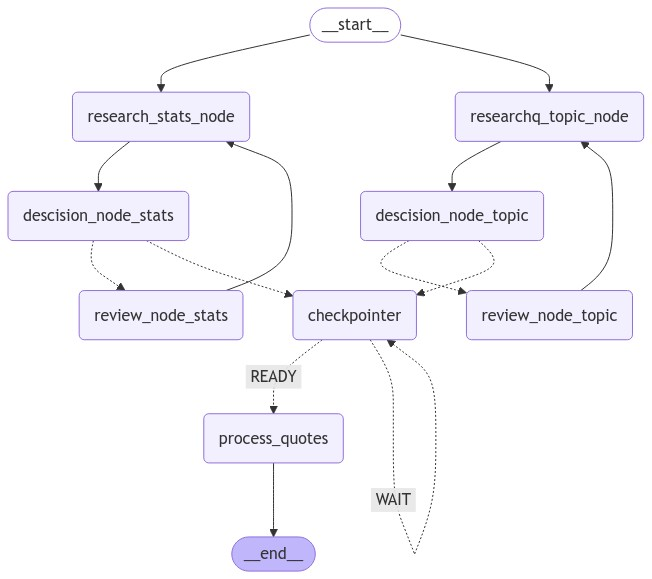

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
# !python -m spacy download en_core_web_sm
# Check how to deploy this 

In [18]:
thread = {"configurable": {"thread_id": "0"}}

graph = workflow.compile()



all_responses = []

for s in graph.stream(
        {"topic": "Fender guitars",
         "writing_examples": ["""Target High-potential Markets
Despite the general growth, the success—in terms of both user penetration and monetary returns—remains within major use cases. Research regional policies, industrial demands and future applications to adapt your strategy accordingly. In some areas, localised or residential markets can outweigh the potential of grid-scale storage, residential or commercial applications. While in other areas, you might find more potential in the large-scale storage sector. So, it's crucial to identify the market requirements to optimise your strategy.
Prioritise Technological Excellence
Given the rapid evolution of this space, innovation is the key to success. Spend a good chunk of capital on R&D and consider establishing partnerships with academic institutions to remain ahead in terms of technological advancements. Your continued presence in the industry through new product releases, patents and presence at industry events can highlight your commitment to innovation and help you catch the eye of investors.
Put Together an Experienced Team
Energy storage in and of itself is an incredibly complex subject that requires a collaboration of diverse expertise. Recruit a cadre of electrical engineers, chemists, software developers and energy market gurus. Showcase team credentials to build credibility with investors and customers.
Create a Solid Financial Plan
Create detailed financial projections that account for different market scenarios. Explore creative financing models like GM leasing or energy-as-a-service to expand your customer base. A clear path to profitability with achievable projections and goals is crucial for attracting investments.
"""],
         "writing_style": "flexible",
        "stats": [],
        "quotes": [],
        "topic_search": [],
        "topic_search_review": [],
        "stats_review": [],
        "quotes_review": []}
):
    if "__end__" not in s:
        print(s)
        print("----")
        all_responses.append(s)

{'research_stats_node': {'stats': [["Guitar Sales Statistics. These statistics look at the sales of guitars, the industry value overall and just how well they're doing. ... During 2019 Fender's sales of guitars rose by 17%, going from $600 million to a predicted increase of over $700 million in 2020. (CNBC, 2020) ... 2023 at 2:37 pm Just wondering— Around 1965, there were", 'https://www.guitarinsideout.com/guitar-industry-statistics/'], ['Here are some guitar sales statistics that can be found: ... In 2020, Fender accounted for 17% of all guitar sales in the United States. (Guitar World) In 2019, Fender was the top-selling guitar brand in the United States, followed by Gibson and Taylor. ... 2023: 3.0 billion: 2024: 3.1 billion: 2025: 3.2 billion: 2026: 3.2 billion: 2027:', 'https://sandymusiclab.com/latest-guitar-industry-statistics-year-trends-market-size-and-sales/'], ["Guitar industry statistics - editor's picks. 50% of aspirational and beginner players are women. (Statista via Stu

C:\Users\Kit\AppData\Local\Temp\ipykernel_31384\1265327875.py:157: SyntaxWarning: invalid escape sequence '\s'
  speaker_pattern = f'{speaking_verbs}\s+([^,\.]+)'
C:\Users\Kit\AppData\Local\Temp\ipykernel_31384\1265327875.py:166: SyntaxWarning: invalid escape sequence '\.'
  speaker_match = re.search(f'([^,\.]+)\s+{speaking_verbs}', before_quote, re.IGNORECASE)


TypeError: expected string or bytes-like object, got 'NoneType'

In [ ]:
for i in all_responses[6]["find_quotes_in_data"]["located_quotes"]:
    print(i)
    print()

In [ ]:
for i in range(len(all_responses[1]["research_stats_node"]["stats"])):
    content = all_responses[1]["research_stats_node"]["stats"][i]["content"]
    url = all_responses[1]["research_stats_node"]["stats"][i]["url"]

    print(f"Stats {content}")
    print(f"URL {url}")

    print("---------")